- sent-level 상관관계
- corpus-level 상관관계
- 레벨별로 나누기
- 바 그래프 그리기
- csv 랜덤 샘플 -> 동일하게 나누기

In [441]:
from tool import processor, correlation, resampling, score
import numpy as np
import pandas as pd
np.__version__

'1.19.5'

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('Qualitative')
plt.rcParams['font.size'] = 12

In [148]:
sns.color_palette('Paired')

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [129]:
import os

In [131]:
IMG_PATH = './img'

In [413]:
HUMAN = 'Human'
META = ['Word', 'Morpheme', 'Subword', 'Character', 'CV']
KHAIII = 'Khaiii'
LEVEL = {'meta':0, 'sub':1}
COLS = [f'sacre{i}' for i in ['Bleu', 'Ter', 'Chrf']]

In [272]:
path = './data/segment_level/raw'
f = processor.FileProcessor(path)
df = f.makeFrame()
df.head(3)

,sacreTer.Hannanum,sacreTer.Khaiii,sacreTer.Kiwi,sacreTer.Kkma,sacreTer.Mecab,sacreTer.Komoran,sacreTer.None,sacreTer.Okt,sacreTer.Spm,sacreBleu.Jamo,...,nltkRibes.Khaiii,nltkRibes.Kiwi,nltkRibes.Kkma,nltkRibes.Komoran,nltkRibes.Mecab,nltkRibes.None,nltkRibes.Okt,nltkRibes.Spm,nltkRibes.Syllable,Human
0,64.7059,50.0,50.0000,47.8261,50.0000,50.0000,77.7778,66.6667,50.0000,53.4154,...,0.2083,0.2083,0.3174,0.2083,0.2165,0.0000,0.0536,0.2165,0.3047,-1.0107
1,56.5217,62.5,54.1667,50.0000,60.0000,54.1667,66.6667,55.5556,59.0909,40.8603,...,0.2274,0.4382,0.3521,0.4382,0.4428,0.3999,0.5888,0.3476,0.3800,-1.0107
2,27.5862,25.0,25.0000,29.0323,25.8065,22.5806,45.4545,33.3333,25.8065,60.0980,...,0.2314,0.2314,0.2333,0.2322,0.2181,0.1743,0.2840,0.2181,0.1787,1.1051


In [490]:
def sub_df(prefix, df):
    """매트릭 별로 컬럼 뽑기"""
    df = change_columns(df)
    return df.loc[:, [col for col in df.columns if col.startswith(prefix)] + [HUMAN]]

def heat_map(df):
    plt.figure(figsize=(7, 5))
    sns.heatmap(df.corr(), annot=True, linewidths=0.2, cmap='Reds')
    plt.show() 
    
def pearson_df(df, level='segment'):
    """피어슨 테이블로 변환"""
    df = df.corr('pearson')[HUMAN]
    df = df.drop(HUMAN)
    
    if level == 'segment':
        # metric 이름 설정
        index0 = df.index[0]
        metric = index0[5:index0.find('.')]
        df.index = [item[item.find('.')+1:] for item in df.index.tolist()]
    
    
    # TER은 음수 변경하기
    metric = level.upper()
    if metric.endswith('TER') or metric == 'EED':
        print(metric)
        df = df.apply(lambda x: x * -1)
        
    return df.to_frame(metric.upper())

def divide_df(df, label=None):
    df['label'] = [0 if idx in META else 1 for idx in df.index]
    if label == LEVEL['sub']:
        return df[df.label==label]
    elif label == LEVEL['meta']:
        sub_df = df[df.label==label]
        # morpheme 평균값 추가하기
        sub_df.loc['Morpheme'] = [np.mean(df[df.label==1].iloc[:, 0]), 0]
        return sub_df
    else:
        return df
    
def run_all(fig_id, df, col='sacreBleu', label=LEVEL['meta'], save=False):
    """
    :param df: 파일에서 가져온 df
    :param metric: 고를 컬럼명
    :param label: meta or sub
    """
    metric_df = sub_df(col, df)
    metric_df = divide_df(pearson_df(metric_df), label=label)
    metric_df = metric_df.sort_values(by=metric_df.columns[0], ascending=False)
    draw(fig_id, metric_df, save=save, label=label)
    return metric_df

In [273]:
def change_columns(df):
    df.columns = [col.replace('None', 'Word')
                     .replace('Jamo', 'CV')
                     .replace('Mecab', 'MeCab')
                     .replace('Syllable', 'Character')
                     .replace('Spm', 'Subword') for col in df.columns]
    return df

In [431]:
def draw(fig_id, df, save=False, label=LEVEL['meta']):
    plt.figure(figsize=(8, 5))
    xlabel = df.columns[0]
    ylabel = 'Pearson r'
    
    # y축 범위 설정
    ymin = round(min(df.iloc[:, 0]) * 0.7, 2)
    ymax = round(max(df.iloc[:, 0]) * 1.1, 2)
    
    color_dict = connect_color(label=label)
    ax = df.plot.bar(y = xlabel,
                     rot = 0, 
                     color = [color_dict[idx] if idx in color_dict \
                                  else 'aquamarine' for idx in df.index],
                     alpha = .9,
                     edgecolor = 'black',
                     hatch = '/')

    plt.ylim([ymin, ymax])
    for p in ax.patches:
        left, bottom, width, height = p.get_bbox().bounds
        print(left, bottom, width, height)
        ax.annotate('{:.3f}'.format(height), 
                    (left + width/2, height), 
                    ha='center', va='bottom')
    ax.get_legend().remove()
    plt.ylabel(ylabel)
    #plt.xlabel(xlabel)
    if save:
        save_figure(fig_id)
    plt.show()

In [430]:
def connect_color(label=LEVEL['meta']):
    if label:
        return {'Khaiii':'salmon'}
    else:
        colors = sns.color_palette('YlOrBr', len(META))
        return {m:c for m, c in zip(META, colors)}
connect_color(False)

{'Word': (0.9987543252595156, 0.9437139561707035, 0.6836908881199539),
 'Morpheme': (0.996078431372549, 0.8091503267973856, 0.39607843137254906),
 'Subword': (0.9949711649365629, 0.5974778931180315, 0.15949250288350636),
 'Character': (0.8836601307189543, 0.39215686274509803, 0.054901960784313725),
 'CV': (0.6635294117647059, 0.23381776239907726, 0.013194925028835063)}

In [391]:
def save_figure(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMG_PATH, fig_id+'.'+fig_extension)
    print('그림 저장: ', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution) ## plt 제공 메소드

### 1. meta-level result

sacreBleu
-0.25 0.0 0.5 0.3120597373694089
0.75 0.0 0.5 0.30610750129175235
1.75 0.0 0.5 0.30085722244915675
2.75 0.0 0.5 0.29616463059296455
3.75 0.0 0.5 0.24982829426905004
그림 저장:  Pearson.seg.meta.Bleu


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


<Figure size 800x500 with 0 Axes>

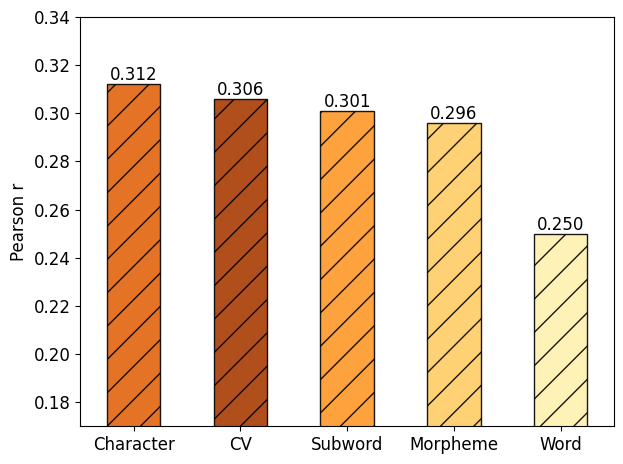

sacreTer
-0.25 0.0 0.5 0.28945840718327426
0.75 0.0 0.5 0.2860312876472393
1.75 0.0 0.5 0.283701030654102
2.75 0.0 0.5 0.2765038219793534
3.75 0.0 0.5 0.23835483917035105
그림 저장:  Pearson.seg.meta.Ter


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


<Figure size 800x500 with 0 Axes>

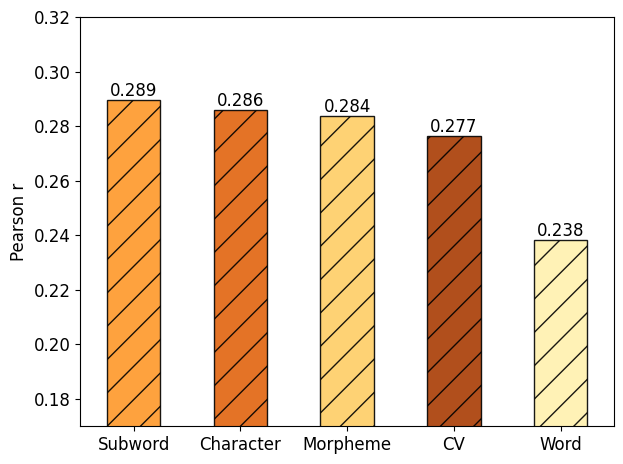

sacreChrf
-0.25 0.0 0.5 0.32578513550044536
0.75 0.0 0.5 0.32303669818257835
1.75 0.0 0.5 0.32224528683000714
2.75 0.0 0.5 0.31990447909535696
3.75 0.0 0.5 0.31602284398430114
그림 저장:  Pearson.seg.meta.Chrf


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


<Figure size 800x500 with 0 Axes>

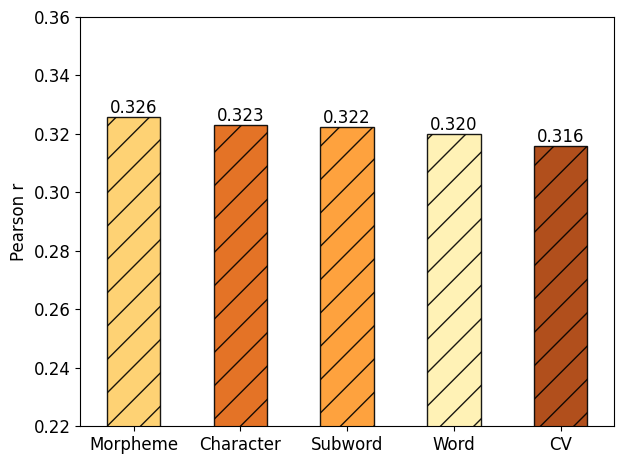

In [434]:
for col in COLS:
    print(col)
    run_all(f'Pearson.seg.meta.{col[5:]}', df, col=col, label=LEVEL['meta'], save=True)

#### Heatmaps

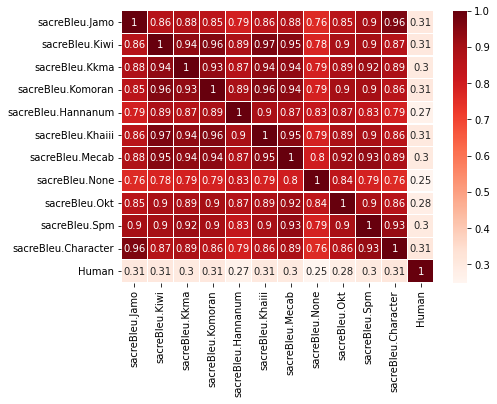

In [24]:
heat_map(bleu)

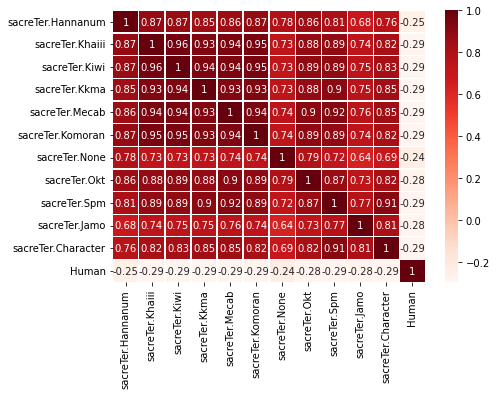

In [25]:
heat_map(ter)

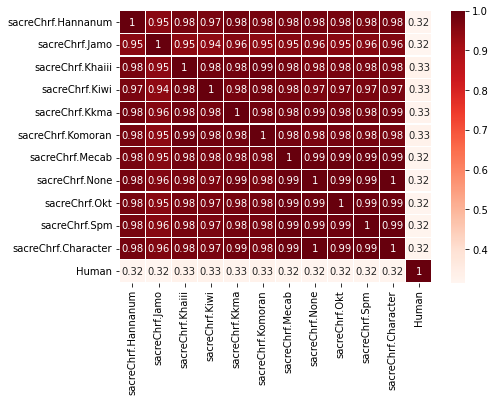

In [26]:
heat_map(chrf)

### 2. morph result

sacreBleu
-0.25 0.0 0.5 0.30738284144931016
0.75 0.0 0.5 0.306200545249357
1.75 0.0 0.5 0.3051130629354001
2.75 0.0 0.5 0.30196405795388886
3.75 0.0 0.5 0.3017845252600121
4.75 0.0 0.5 0.28433021270802233
5.75 0.0 0.5 0.2663771685947614
그림 저장:  Pearson.seg.morph.Bleu


<Figure size 800x500 with 0 Axes>

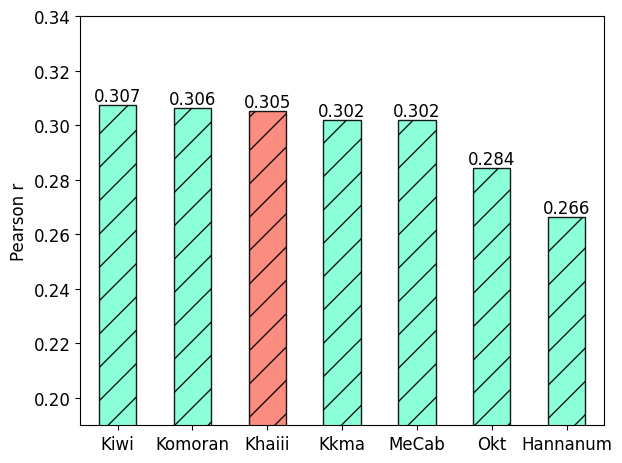

sacreTer
-0.25 0.0 0.5 0.294974359931568
0.75 0.0 0.5 0.2933446080199863
1.75 0.0 0.5 0.29126567519086083
2.75 0.0 0.5 0.28986343702652706
3.75 0.0 0.5 0.288482307878448
4.75 0.0 0.5 0.27763433823519645
5.75 0.0 0.5 0.25034248829612743
그림 저장:  Pearson.seg.morph.Ter


<Figure size 800x500 with 0 Axes>

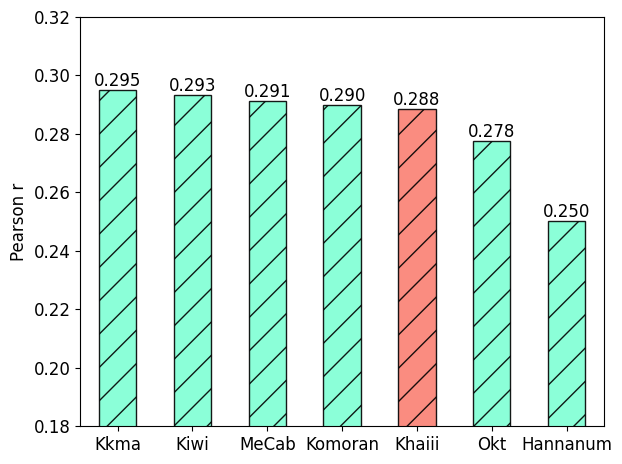

sacreChrf
-0.25 0.0 0.5 0.3304863001455162
0.75 0.0 0.5 0.33016746057351454
1.75 0.0 0.5 0.3295193375675344
2.75 0.0 0.5 0.32637968810783796
3.75 0.0 0.5 0.3230243413111774
4.75 0.0 0.5 0.3208228137411719
5.75 0.0 0.5 0.3200960070563649
그림 저장:  Pearson.seg.morph.Chrf


<Figure size 800x500 with 0 Axes>

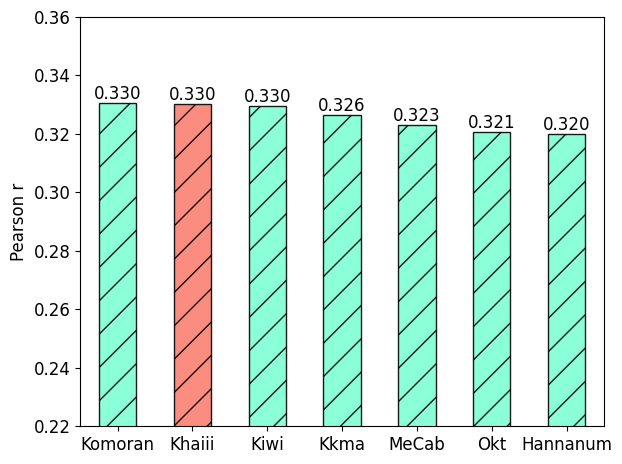

In [435]:
for col in COLS:
    print(col)
    run_all(f'Pearson.seg.morph.{col[5:]}', df, col=col, label=LEVEL['sub'], save=True)

### 3. corpus: meta-level

In [462]:
PATH_CORP = './data/corpus_level'
#f = processor.FileProcessor(path_corpus)
file_list = [f for f in os.listdir(PATH_CORP) if not f.endswith('checkpoints')]
file_list

['chrf.csv',
 'ter.csv',
 'bleu.csv',
 'CharacTER.csv',
 'EED.csv',
 'nltkBleu.csv',
 'nltkGleu.csv',
 'nltkNist.csv',
 'nltkRibes.csv']

In [488]:
def corpus_result(fig_id, file, save=False, label=LEVEL['meta']):
    # open
    metric = file[:-4].upper()
    df = pd.read_csv(os.path.join(PATH_CORP, file), index_col=0)
    df = change_columns(df.T)
    
    # to pearson
    df = pearson_df(df, level=metric)
    
    # extract by label
    df = divide_df(df, label=label)
    df = df.sort_values(by=df.columns[0], ascending=False)
    
    # draw figure
    draw(fig_id, df, save=save, label=label)
    return df

In [494]:
temp = pd.read_csv(os.path.join(path_corpus, 'EED.csv'), index_col=0)
temp = change_columns(temp.T)
temp

,Human,Word,Okt,MeCab,Komoran,Kkma,Kiwi,Khaiii,Hannanum,Subword,CV,Character
Sys_B,0.111834,5.033448e+15,4.695622e+15,4.542673e+16,4.476779e+15,4.450566e+15,4.444365e+15,4.472111e+14,4.604804e+15,4.424120e+15,3.398152e+15,4.035129e+15
Sys_A,0.203293,5.091758e+14,4.750806e+15,4.592781e+16,4.517135e+15,4.495913e+16,4.490854e+16,4.515359e+16,4.654374e+15,4.475781e+16,3.424728e+15,4.077255e+16
Sys_P,0.027391,5.324296e+15,4.940034e+15,4.775026e+15,4.715464e+16,4.692473e+16,4.662943e+15,4.702506e+14,4.867661e+15,4.645592e+16,3.598089e+15,4.239310e+16
Sys_Q,-0.220158,5.243847e+15,4.883129e+16,4.733562e+15,4.661410e+16,4.639414e+16,4.634030e+15,4.664889e+15,4.799380e+16,4.611808e+14,3.555456e+15,4.200088e+07


In [495]:
temp = temp.corr()['Human'].to_frame('EED')
temp

,EED
Human,1.000000
Word,-0.651310
Okt,-0.920115
MeCab,0.807973
Komoran,-0.800649
Kkma,-0.321542
Kiwi,0.630548
Khaiii,0.561601
Hannanum,-0.920314
Subword,0.573825


In [497]:
divide_df(temp, label=0)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,EED,label
Word,-0.651310,0.0
Subword,0.573825,0.0
CV,-0.666021,0.0
Character,0.578419,0.0
Morpheme,0.004688,0.0


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


-0.25 0.0 0.5 0.6136267102471993
0.75 0.0 0.5 0.5960813272112352
1.75 0.0 0.5 0.5767974280624985
2.75 0.0 0.5 0.5620182452824185
3.75 0.0 0.5 0.5564167366058439
그림 저장:  Pearson.corp.meta.chrf


<Figure size 800x500 with 0 Axes>

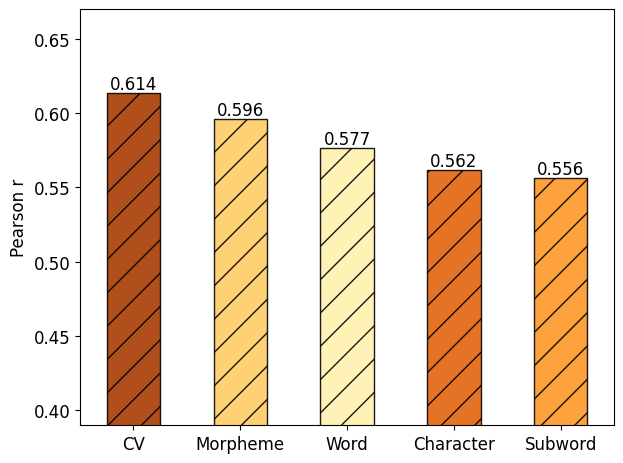

-0.25 0.0 0.5 0.6444798902423815
0.75 0.0 0.5 0.6282840756195954
1.75 0.0 0.5 0.60102528392579
2.75 0.0 0.5 0.5962094946547587
3.75 0.0 0.5 0.5844679506977414
4.75 0.0 0.5 0.5733967847225472
5.75 0.0 0.5 0.5447058106158317
그림 저장:  Pearson.corp.morph.chrf


<Figure size 800x500 with 0 Axes>

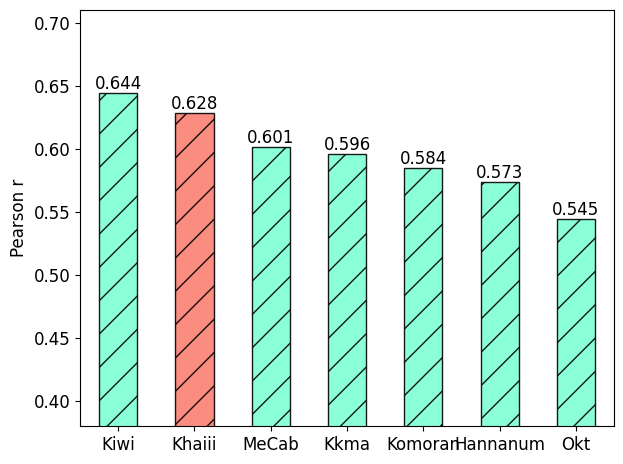

TER
-0.25 0.0 0.5 0.8700869817703022
0.75 0.0 0.5 0.7936701292937325
1.75 0.0 0.5 0.5945527629608509
2.75 0.0 0.5 0.54865705191613
3.75 0.0 0.5 0.4628916713269638
그림 저장:  Pearson.corp.meta.ter


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


<Figure size 800x500 with 0 Axes>

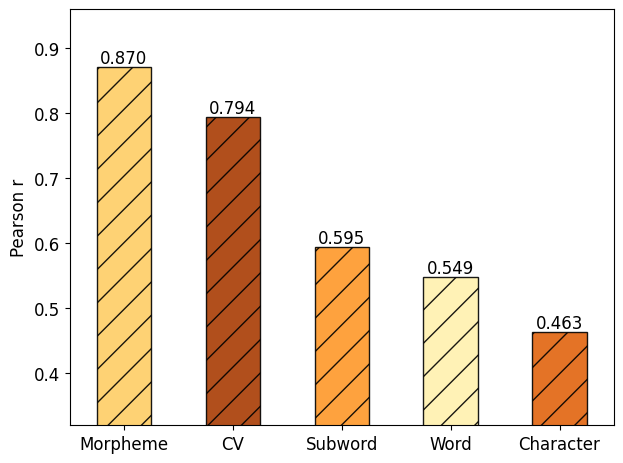

TER
-0.25 0.0 0.5 0.9328945803123215
0.75 0.0 0.5 0.9210181867841816
1.75 0.0 0.5 0.9114030262683184
2.75 0.0 0.5 0.8932609413586008
3.75 0.0 0.5 0.8749975936394615
4.75 0.0 0.5 0.7940082228416522
5.75 0.0 0.5 0.7630263211875797
그림 저장:  Pearson.corp.morph.ter


<Figure size 800x500 with 0 Axes>

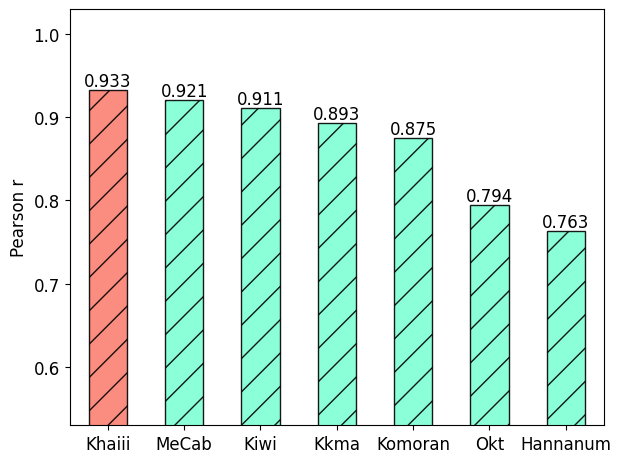

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


-0.25 0.0 0.5 0.6997233691911091
0.75 0.0 0.5 0.6530812640273965
1.75 0.0 0.5 0.5441806585246167
2.75 0.0 0.5 0.5320174348929678
3.75 0.0 0.5 0.5075993866233742
그림 저장:  Pearson.corp.meta.bleu


<Figure size 800x500 with 0 Axes>

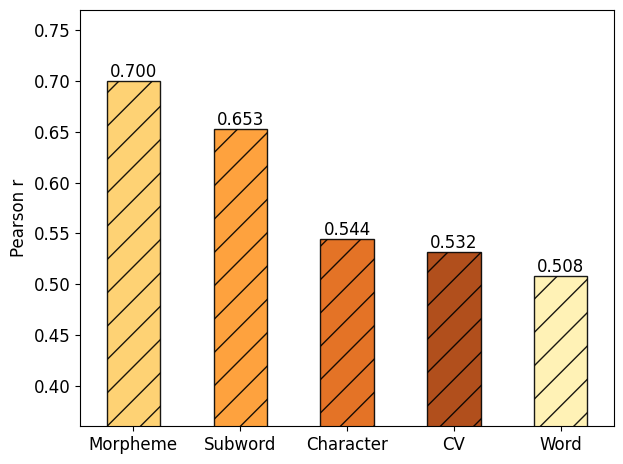

-0.25 0.0 0.5 0.7811308923708847
0.75 0.0 0.5 0.7675807927515136
1.75 0.0 0.5 0.7540616553411518
2.75 0.0 0.5 0.6913674550189399
3.75 0.0 0.5 0.66704671577688
4.75 0.0 0.5 0.6356718952866649
5.75 0.0 0.5 0.6012041777917291
그림 저장:  Pearson.corp.morph.bleu


<Figure size 800x500 with 0 Axes>

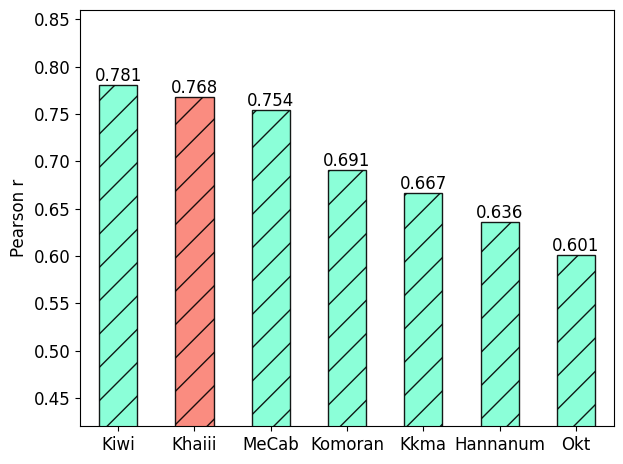

CHARACTER
-0.25 0.0 0.5 0.6802909061491815
0.75 0.0 0.5 0.6131373470583263
1.75 0.0 0.5 0.5854987753933256
2.75 0.0 0.5 0.4777142354851743
3.75 0.0 0.5 0.45740425014065644
그림 저장:  Pearson.corp.meta.CharacTER


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


<Figure size 800x500 with 0 Axes>

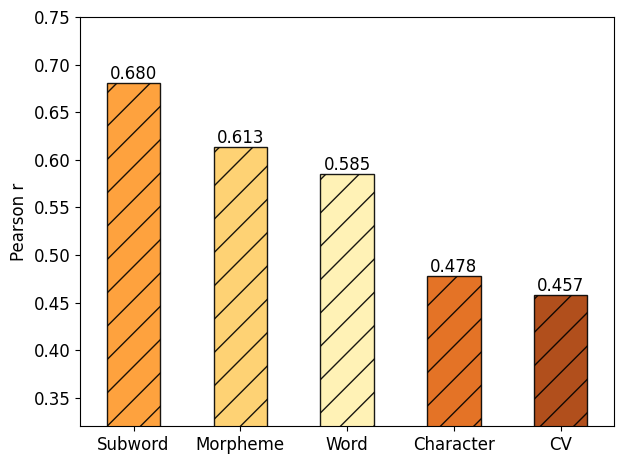

CHARACTER
-0.25 0.0 0.5 0.6920271738171477
0.75 0.0 0.5 0.6546047467305341
1.75 0.0 0.5 0.6218600562012365
2.75 0.0 0.5 0.6204601829984032
3.75 0.0 0.5 0.6179714446484232
4.75 0.0 0.5 0.5619106603876424
5.75 0.0 0.5 0.5231271646248976
그림 저장:  Pearson.corp.morph.CharacTER


<Figure size 800x500 with 0 Axes>

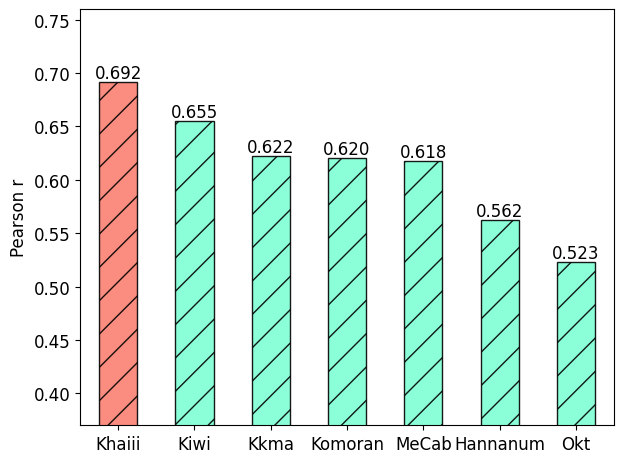

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


-0.25 0.0 0.5 0.7385093490263123
0.75 0.0 0.5 0.6986707697061771
1.75 0.0 0.5 0.6971352955804817
2.75 0.0 0.5 0.6888060314127421
3.75 0.0 0.5 0.6197322437308154
그림 저장:  Pearson.corp.meta.nltkBleu


<Figure size 800x500 with 0 Axes>

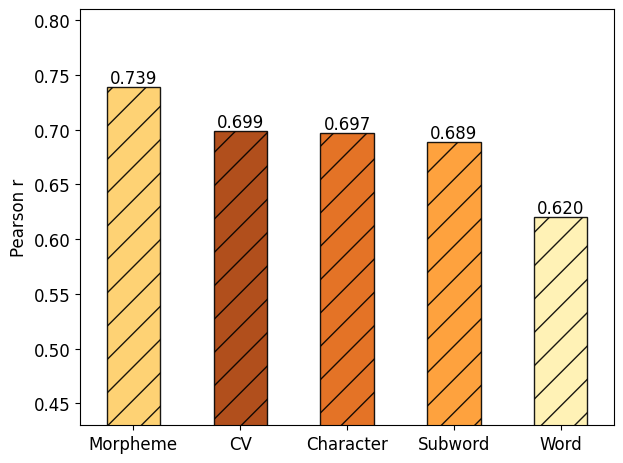

-0.25 0.0 0.5 0.8144791935579668
0.75 0.0 0.5 0.8019260460085057
1.75 0.0 0.5 0.7930653627579332
2.75 0.0 0.5 0.7376399550625233
3.75 0.0 0.5 0.716875268027565
4.75 0.0 0.5 0.6603346589623463
5.75 0.0 0.5 0.6452449588073452
그림 저장:  Pearson.corp.morph.nltkBleu


<Figure size 800x500 with 0 Axes>

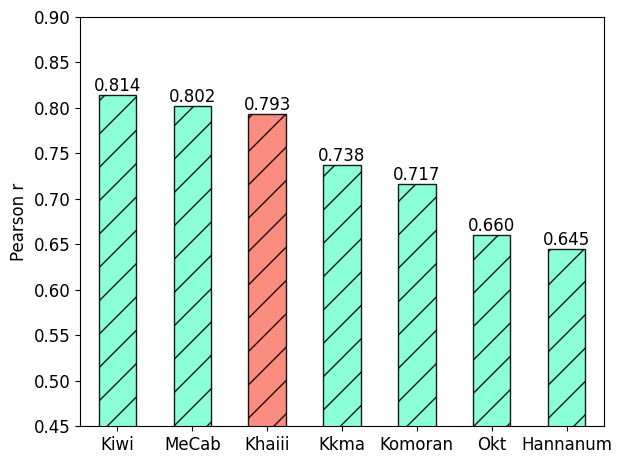

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


-0.25 0.0 0.5 0.7539406493849274
0.75 0.0 0.5 0.6754560254302289
1.75 0.0 0.5 0.6718936716054698
2.75 0.0 0.5 0.6652185926016857
3.75 0.0 0.5 0.5349997715456594
그림 저장:  Pearson.corp.meta.nltkGleu


<Figure size 800x500 with 0 Axes>

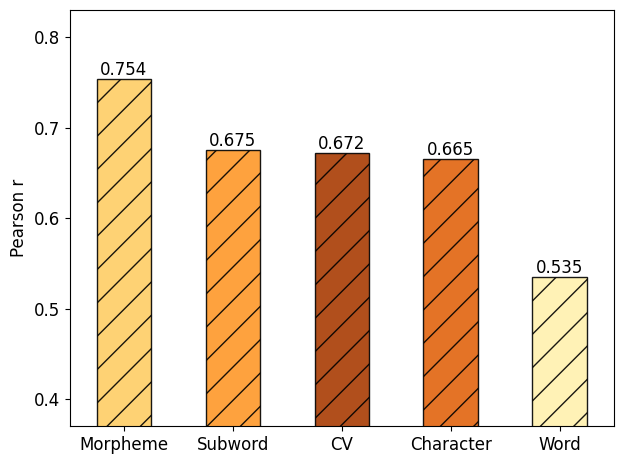

-0.25 0.0 0.5 0.8334479396255897
0.75 0.0 0.5 0.8164718612563684
1.75 0.0 0.5 0.8157224356650459
2.75 0.0 0.5 0.7484116799271346
3.75 0.0 0.5 0.7398529483174726
4.75 0.0 0.5 0.6644720177540198
5.75 0.0 0.5 0.6592056631488611
그림 저장:  Pearson.corp.morph.nltkGleu


<Figure size 800x500 with 0 Axes>

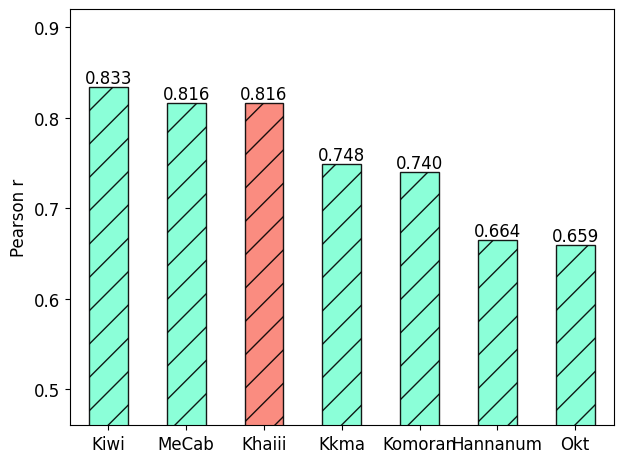

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


-0.25 0.0 0.5 0.6990420650844479
0.75 0.0 0.5 0.591269389856982
1.75 0.0 0.5 0.49528205209303533
2.75 0.0 0.5 0.4877343443862004
3.75 0.0 0.5 0.43598885409568666
그림 저장:  Pearson.corp.meta.nltkNist


<Figure size 800x500 with 0 Axes>

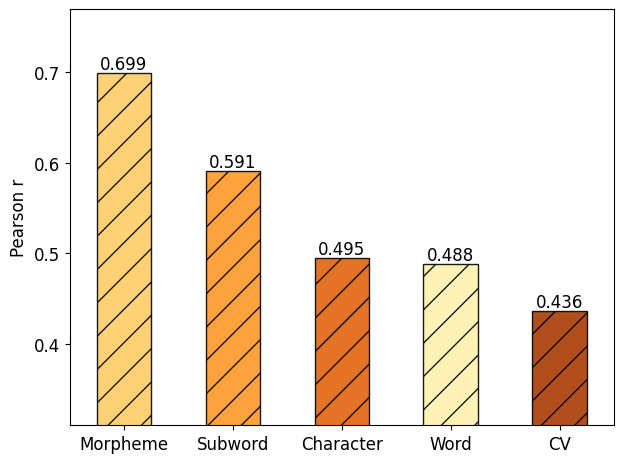

-0.25 0.0 0.5 0.7864208276972353
0.75 0.0 0.5 0.7845484426754707
1.75 0.0 0.5 0.7647959049324812
2.75 0.0 0.5 0.6949575511274024
3.75 0.0 0.5 0.6606159167065142
4.75 0.0 0.5 0.616296582730999
5.75 0.0 0.5 0.5856592297210332
그림 저장:  Pearson.corp.morph.nltkNist


<Figure size 800x500 with 0 Axes>

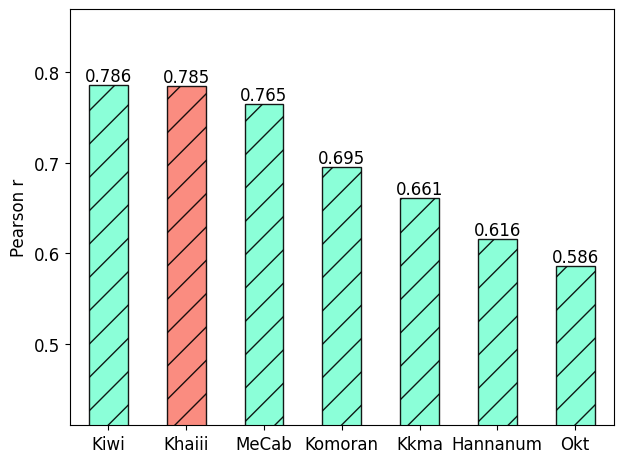

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


-0.25 0.0 0.5 0.9392031305466352
0.75 0.0 0.5 0.923497118144308
1.75 0.0 0.5 0.9117398579463508
2.75 0.0 0.5 0.8777858986857573
3.75 0.0 0.5 0.7508259375404007
그림 저장:  Pearson.corp.meta.nltkRibes


<Figure size 800x500 with 0 Axes>

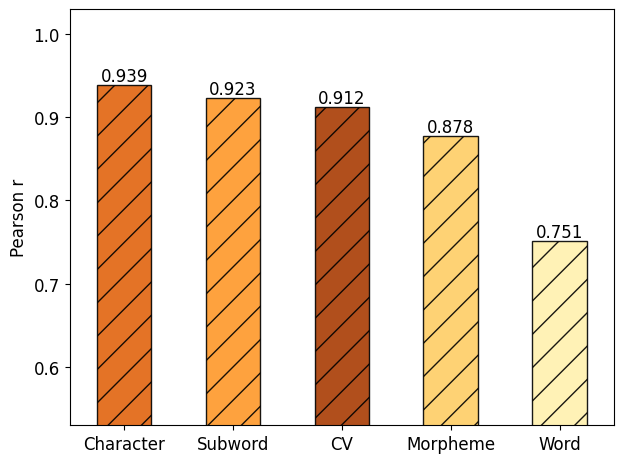

-0.25 0.0 0.5 0.9446148676557414
0.75 0.0 0.5 0.9351722742567617
1.75 0.0 0.5 0.9101940736677265
2.75 0.0 0.5 0.8825287935813599
3.75 0.0 0.5 0.8785167619489856
4.75 0.0 0.5 0.8140864457100578
5.75 0.0 0.5 0.7793880739796678
그림 저장:  Pearson.corp.morph.nltkRibes


<Figure size 800x500 with 0 Axes>

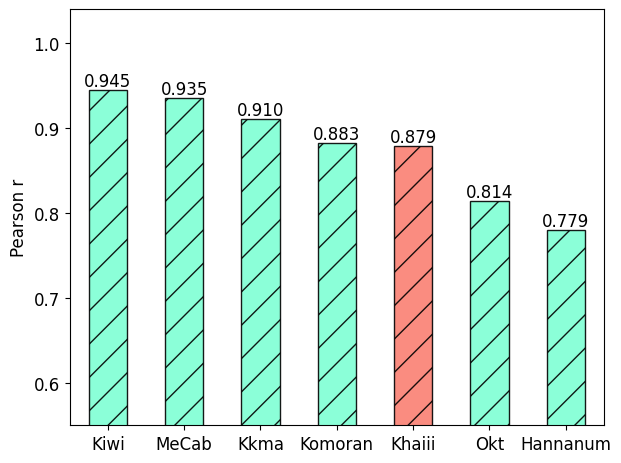

In [501]:
for file in file_list:
    #print(file)
    if file[:-4] != 'EED':
        for label in LEVEL.values():
            level = ['meta' if label == 0 else 'morph']
            corpus_result(fig_id=f'Pearson.corp.{level[0]}.{file[:-4]}',
                             file=file,
                             save=True,
                             label=label)

In [472]:
LEVEL.values()

dict_values([0, 1])